# RNN

*Recurent Neural Network*

再帰型ニューラルネットワーク。  
再帰的な構造を持つニューラルネットワークで、可変長の時系列データを扱うことが得意。

<u>2章: 深層学習を用いた言語モデル</u>では、深層学習を活用して、ある単語から次の単語を予測するモデルを作成した。しかし、これでは文脈を考慮できない。具体的には、2つ以上前の単語を考慮した予測が出来ない。  
RNNを用いることで、文脈を考慮した予測が可能になる。

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from dlprog import train_progress

In [2]:
prog = train_progress()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')


---

## RNNの構造

RNNはある時間$t$の入力$x_t$に対して以下のような演算を行い、出力値$h_t$を決定する。

$$
h_t = \mathrm{tanh}(W_x x_t + b_x + W_h h_{t-1} + b_h)
$$

演算の内部で前の時間の出力値$h_{t-1}$を参照していることが分かる。  
演算内容はシンプルに捉えることができて、入力$x_t$と前の時間の出力$h_{t-1}$をそれぞれ線形変換し、それらの和を活性化関数$\mathrm{tanh}$に通しているだけ。線形変換に必要な重みとバイアスが2つずつあるので、パラメータは合計4つ。

実装してみるとこんな感じ。

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc_input = nn.Linear(input_size, output_size)
        self.fc_output = nn.Linear(output_size, output_size)

    def forward(self, x, h):
        z = self.fc_input(x) + self.fc_output(h)
        h = F.tanh(z)
        return h

### 推論

推論の流れを見てみる。

まず適当なパラメータで出力の初期値$h_0$と初めの入力$x_1$を定義する。$h_0$は0ベクトルで良い。

In [4]:
batch_size, input_size, hidden_size = 2, 3, 4
x1 = torch.randn(batch_size, input_size)
h0 = torch.zeros(batch_size, hidden_size)

rnn = RNN(input_size, hidden_size)
h1 = rnn(x1, h0)
h1

tensor([[-0.0677,  0.8438,  0.6604, -0.7478],
        [ 0.8460, -0.3198, -0.5337, -0.2675]], grad_fn=<TanhBackward0>)

この$h_1$を参照して、次の時間の入力$x_2$に対する出力$h_2$を決定する。

In [5]:
x2 = torch.randn(batch_size, input_size)
h2 = rnn(x2, h1)
h2

tensor([[ 0.5454,  0.1997, -0.7101,  0.7949],
        [-0.9225,  0.7145,  0.1664,  0.5927]], grad_fn=<TanhBackward0>)

これがRNNの推論の流れである。これを繰り返すことで、時系列的な情報を保持しながら推論を行うことが出来る。

また、基本的には、モデルでの時間ごとの出力にRNNの出力$h_t$をそのまま用いることはない。$h_t$を更に幾つかの層に通して、最終的な出力を決定する。RNNが一つの層になっている感じ。  
$h_t$が直接観測されることはないため、潜在変数や隠れ状態と表現される。変数名に$y$ではなく$h$を使っている理由がそこにある（隠れる=hide）。


---

## PyTorchでの実装

PyTorchにはRNNを実装するためのクラスが用意されている。軽く紹介する。

### `torch.nn.RNNCell`

RNNの一つの時間の演算を行うクラス。↑で実装したものと同じ。  
[RNNCell — PyTorch 2.0 documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html)

In [6]:
batch_size, input_size, hidden_size = 2, 3, 4

rnn = nn.RNNCell(input_size, hidden_size)
for params in rnn.parameters():
    print(params, '\n')

Parameter containing:
tensor([[-1.3733e-04, -1.9070e-01,  4.1039e-01],
        [ 3.7205e-01, -9.6222e-02,  1.4783e-01],
        [ 2.2649e-01, -4.0359e-01, -1.4207e-01],
        [ 8.6847e-02, -1.7854e-01,  4.5246e-01]], requires_grad=True) 

Parameter containing:
tensor([[ 0.1036, -0.0659, -0.0401, -0.3472],
        [-0.2379,  0.0934,  0.3760, -0.0491],
        [-0.3658,  0.2417, -0.0750, -0.1383],
        [-0.0258, -0.1908,  0.0093,  0.4810]], requires_grad=True) 

Parameter containing:
tensor([ 0.1981, -0.0508,  0.2737,  0.4274], requires_grad=True) 

Parameter containing:
tensor([-0.2198,  0.3115,  0.4053, -0.3478], requires_grad=True) 



パラメータが4つ。

In [7]:
x1 = torch.randn(batch_size, input_size)
rnn(x1)

tensor([[-0.5748, -0.2201,  0.6006, -0.5878],
        [ 0.4264,  0.2333,  0.0609,  0.5286]], grad_fn=<TanhBackward0>)

$h$を入力しなかった場合は勝手に0ベクトルになる。

### `torch.nn.RNN`

全ての時間の演算をまとめて行うクラス。  
[RNN — PyTorch 2.0 documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)



In [8]:
batch_size, input_size, hidden_size, seq_length = 2, 3, 4, 5
rnn = nn.RNN(input_size, hidden_size, batch_first=True)

x = torch.randn(batch_size, seq_length, input_size)
y, h = rnn(x)
y.shape

torch.Size([2, 5, 4])

バッチごとに全ての時間の隠れ状態が出力される。  
また`h`には最後の時間の隠れ状態が出力される。

In [9]:
y[:, -1] == h

tensor([[[True, True, True, True],
         [True, True, True, True]]])

In [10]:
h.shape

torch.Size([1, 2, 4])

初めに次元が1つ追加されるのは仕様。


---

## sin波の生成

与えられたsin波から続きを生成するモデルを作ろう。

### データセット

ノイズの加わったsin波をデータセットとして用意する。

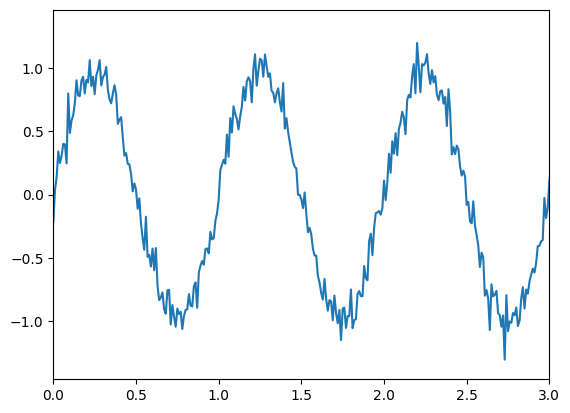

In [11]:
freq, sr, n_samples = 1, 100, 10000
t = torch.arange(0, n_samples / sr, 1 / sr)
noise = torch.randn(n_samples) * 0.1
sin = torch.sin(2 * torch.pi * freq * t)
seq = sin + noise
plt.plot(t, seq)
plt.xlim(0, 3);


### NN

まずは通常のNNで学習させてみよう。

n個の値から次の値を予測するモデルを作る。

In [12]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
input_size, hidden_size = 50, 100
model = Model(input_size, hidden_size)

次に学習データを用意する。  
連続したn個の値をそれに続く一つの値をペアとして用意する。

In [14]:
class SinDataset(Dataset):
    def __init__(self, seq):
        self.seq = seq
        self.n_data = n_samples - input_size

    def __getitem__(self, idx):
        seq = self.seq[idx:idx + input_size + 1]
        return seq[:-1], seq[-1]

    def __len__(self):
        return self.n_data

batch_size = 64
dataset = SinDataset(seq)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

学習させてみよう。

In [15]:
def train(model, optimizer, n_epochs):
    model.train()
    prog.start(n_iter=len(dataloader), n_epochs=n_epochs)
    for _ in range(n_epochs):
        for x, y in dataloader:
            optimizer.zero_grad()
            pred = model(x)
            loss = F.mse_loss(pred.ravel(), y)
            loss.backward()
            optimizer.step()
            prog.update(loss.item())

In [16]:
optimizer = optim.Adam(model.parameters())
train(model, optimizer, 5)

1/5: ######################################## 100% [00:00:00.30] loss: 0.02317 
2/5: ######################################## 100% [00:00:00.31] loss: 0.01117 
3/5: ######################################## 100% [00:00:00.31] loss: 0.01107 
4/5: ######################################## 100% [00:00:00.30] loss: 0.01097 
5/5: ######################################## 100% [00:00:00.30] loss: 0.01081 


予測してみよう。

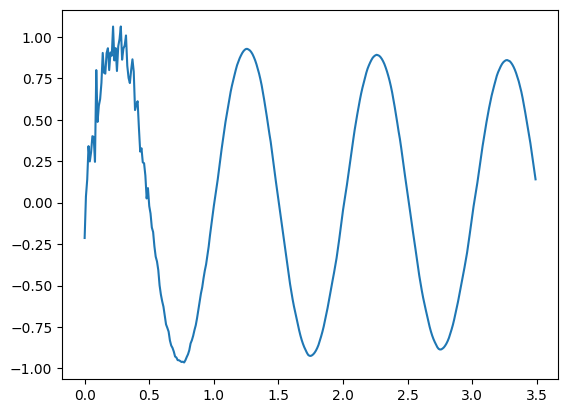

In [17]:
pred_seq = seq[:input_size]
n_preds = 3 * sr
for _ in range(n_preds):
    with torch.no_grad():
        x = pred_seq[-input_size:]
        pred = model(x)
        pred_seq = torch.cat([pred_seq, pred])
plt.plot(t[:len(pred_seq)], pred_seq);

初めのn個の値から、それに続く値を予測することが出来た。

### RNN

では、今度はRNNを用いて学習させてみよう。